In [2]:
# import get_BEV, torch 等
import cv2
import matplotlib.pyplot as plt
import time
import torch
import cv2 as cv
import math
from scipy.spatial.transform import Rotation
import numpy as np

def get_BEV_tensor(img,Ho, Wo, Fov = 170, dty = -20, dx = 0, dy = 0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    t0 = time.time()

    if len(img.shape) ==3 :
        Hp, Wp , _ = img.shape                                # 全景图尺寸
    else:
        Hp, Wp  = img.shape                                # 全景图尺寸
    if dty != 0 or Wp != 2*Hp:
        ty = (Wp/2-Hp)/2 + dty                                                 # 非标准全景图补全
        matrix_K = np.array([[1,0,0],[0,1,ty],[0,0,1]])
        img = cv.warpPerspective(img,matrix_K,(int(Wp),int(Hp+(Wp/2-Hp))))
    ######################
    t1 = time.time()
    frame = torch.from_numpy(img).to(device)  
    t2 = time.time()

    if len(frame.shape) ==3 :
        Hp, Wp , _ = frame.shape                                # 全景图尺寸
    else:
        Hp, Wp  = frame.shape                                # 全景图尺寸
    # Wp, Hp = 16384, 8192                                # 全景图尺寸
    Fov = 170 * torch.pi / 180                               # 视场角
    center = torch.tensor([Wp/2+dx,Hp+dy]).to(device)                  # 俯瞰图中心
    # Ho, Wo =  500,500                                        # 俯瞰图尺寸

    anglez = center[0] * 2 * torch.pi / Wp
    angley = torch.pi / 2 - center[1] * torch.pi / Hp

    f = Wo/2/torch.tan(torch.tensor(Fov/2))
    r = Rotation.from_euler('zy',[anglez.cpu(),angley.cpu()], degrees=False)
    R02 = torch.from_numpy(r.as_matrix()).float().to(device)
    out = torch.zeros((Wo, Ho,2)).to(device)
    f0 = torch.zeros((Wo, Ho,3)).to(device)  
    f0[:,:,0] = torch.ones((Wo, Ho)).to(device) *f
    f0[:,:,1] = -Wo/2 + torch.ones((Ho, Wo)).to(device)  *torch.arange(Wo).to(device)  
    f0[:,:,2] = -Ho/2 + (torch.ones((Ho, Wo)).to(device)  *(torch.arange(Ho)).to(device)).T
    f1 = R02@ f0.reshape((-1,3)).T  # x,y,z (3*N)
    f1_0 = torch.sqrt(torch.sum(f1**2,0))
    f1_1 = torch.sqrt(torch.sum(f1[:2,:]**2,0))
    theta = torch.arccos(f1[2,:]/f1_0)
    phi = torch.arccos(f1[0,:]/f1_1)
    mask = f1[1,:] <  0 
    phi[mask] = 2 * torch.pi - phi[mask]
    #################################
    phi = 2 * torch.pi - phi+ torch.pi
    mask = phi >  2 * torch.pi 
    phi[mask] = phi[mask] - 2 * torch.pi 
    #################################
    i_p = theta  / torch.pi * Hp
    j_p = phi  / (2 * torch.pi) * Wp
    out[:,:,0] = i_p.reshape((Ho, Wo))
    out[:,:,1] = j_p.reshape((Ho, Wo))
    t3 = time.time()


    src0 = torch.floor(out).int().to(device)
    src1 = src0 + torch.ones(src0.shape, dtype= int).to(device)

    mask = src0[:,:,0] >=  Hp
    src0[:,:,0][mask] = ((torch.ones(out.shape, dtype= int)[:,:,0]*(Hp-1)).to(device)[mask]).int()
    mask = src0[:,:,1] >= Wp
    src0[:,:,1][mask] = ((torch.ones(out.shape, dtype= int)[:,:,0]*(Wp-1)).to(device)[mask]).int()

    mask = src1[:,:,0] >=  Hp
    src1[:,:,0][mask] = (torch.ones(out.shape, dtype= int)[:,:,0]*(Hp-1)).to(device)[mask]
    mask = src1[:,:,1] >= Wp
    src1[:,:,1][mask] = (torch.ones(out.shape, dtype= int)[:,:,0]*(Wp-1)).to(device)[mask]

    d = out - src0
    w0 = ((1 - d[:,:,1])*(1 - d[:,:,0])).reshape((Ho,Wo,1))
    w1 = (d[:,:,1]*(1 - d[:,:,0])).reshape((Ho,Wo,1))
    w2 = ((1 - d[:,:,1])*d[:,:,0]).reshape((Ho,Wo,1))
    w3 = (d[:,:,1]*d[:,:,0]).reshape((Ho,Wo,1))

    # BEV[Ho - 1 - i,j] = w0 * img[srcV0,srcU0] + w1 * img[srcV0,srcU1] + w2 * img[srcV1,srcU0] + w3 * img[srcV1,srcU1]
    BEV =w0*frame[src0[:,:,0].long(),src0[:,:,1].long()] + w1*frame[src0[:,:,0].long(),src1[:,:,1].long()]+w2*frame[src1[:,:,0].long(),src0[:,:,1].long()]+ w3*frame[src1[:,:,0].long(),src1[:,:,1].long()]

    t4  = time.time()
    # plt.imshow(BEV.cpu().int()[:,:,[2,1,0]])
    # plt.imshow(img[out.astype(int)[:,:,0],out.astype(int)[:,:,1]].astype(int)[:,:,[2,1,0]])
    print("Read image ues {:.2f} ms, warpPerspective image use {:.2f} ms, Get matrix ues {:.2f} ms, Get out ues {:.2f} ms, All out ues {:.2f} ms.".format((t1-t0)*1000,(t2-t1)*1000, (t3-t2)*1000,(t4-t3)*1000,(t4-t0)*1000))
    return BEV.cpu().int()

In [3]:
import matplotlib.pyplot as plt
import matplotlib
def make_matching_figure(
        img0, img1, mkpts0, mkpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None):
    # draw image pair
    assert mkpts0.shape[0] == mkpts1.shape[0], f'mkpts0: {mkpts0.shape[0]} v.s. mkpts1: {mkpts1.shape[0]}'
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=dpi)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')
    for i in range(2):   # clear all frames
        axes[i].get_yaxis().set_ticks([])
        axes[i].get_xaxis().set_ticks([])
        for spine in axes[i].spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)
    
    if kpts0 is not None:
        assert kpts1 is not None
        axes[0].scatter(kpts0[:, 0], kpts0[:, 1], c='w', s=2)
        axes[1].scatter(kpts1[:, 0], kpts1[:, 1], c='w', s=2)

    # draw matches
    if mkpts0.shape[0] != 0 and mkpts1.shape[0] != 0:
        fig.canvas.draw()
        transFigure = fig.transFigure.inverted()
        fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
        fig.lines = [matplotlib.lines.Line2D((fkpts0[i, 0], fkpts1[i, 0]),
                                            (fkpts0[i, 1], fkpts1[i, 1]),
                                            transform=fig.transFigure, c=color[i], linewidth=1)
                                        for i in range(len(mkpts0))]
        
        axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=4)
        axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=4)

    # put txts
    txt_color = 'k' if img0[:100, :200].mean() > 200 else 'w'
    fig.text(
        0.01, 0.99, '\n'.join(text), transform=fig.axes[0].transAxes,
        fontsize=15, va='top', ha='left', color=txt_color)

    # save or return figure
    if path:
        plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return fig

In [4]:
# 读入匹配网络
from match_pairs import *
from models.utils import read_image_wxl
import cv2
import time
import matplotlib.pyplot as plt
import sys

torch.set_grad_enabled(False)

# 设置相关参数
parser = set_pares()    
# opt = parser.parse_args(args=['--superglue', 'outdoor','--resize','640','640'])
opt = parser.parse_args(args=['--superglue', 'outdoor'])
# with open(opt.input_pairs, 'r') as f:
#     pairs = [l.split() for l in f.readlines()]

# 加载模型
device = 'cuda' if torch.cuda.is_available() and not opt.force_cpu else 'cpu'
config = {
    'superpoint': {
        'nms_radius': opt.nms_radius,
        'keypoint_threshold': opt.keypoint_threshold,
        'max_keypoints': opt.max_keypoints
    },
    'superglue': {
        'weights': opt.superglue,
        'sinkhorn_iterations': opt.sinkhorn_iterations,
        'match_threshold': opt.match_threshold,
    }
}
matching = Matching(config).eval().to(device)
matching.superglue.bin_score

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


Parameter containing:
tensor(4.4124, device='cuda:0', requires_grad=True)

Read image ues 2.74 ms, warpPerspective image use 0.48 ms, Get matrix ues 229.86 ms, Get out ues 5.30 ms, All out ues 238.37 ms.


/data/anaconda3/envs/wxl_vit/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Network use 569.05 ms
1024 1024 606 138


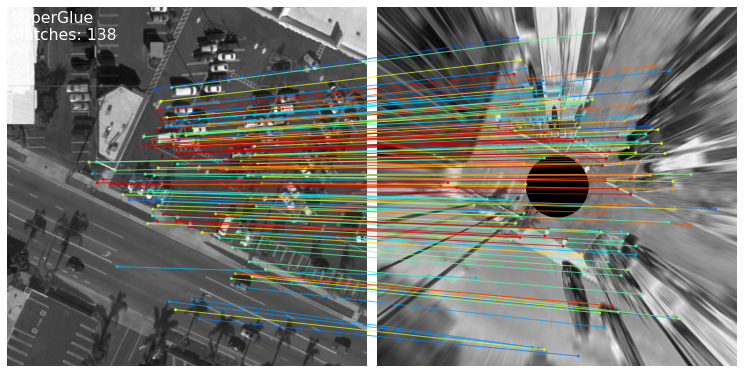

In [5]:
# matplotlib.use('TkAgg')
%matplotlib inline
# img_path0 = "/home/wxl/图片/004.png" 
idx = 44
img_path0 = "/data/wxl/Data/CVUSA/bingmap/20/{:07}.jpg".format(idx)
# img_path0 = '/home/wxl/ZJU/graduate/satellite_related/pano2Planet/build/data/sat_20.png'
# img_path1 = '/home/wxl/ZJU/graduate/satellite_related/pano2Planet/build/data/temp.png'
# img_path0 = "/home/wxl/图片/004.png"
# img_path0 = '/home/wxl/ZJU/graduate/satellite_rela ted/Date_self/Google_sat_map/0002_19.png'
# img_path0 = '/home/wxl/ZJU/graduate/satellite_related/getmap/satellite-imagery-downloader/src/images/img_20221129102816.png'
img_path1 = '/data/wxl/ZJU/graduate/satellite_related/pano2Planet/build/data/BEV_0051_LH.png'
ImgPath = '/data/wxl/Data/CVUSA/streetview/panos/{:07}.jpg'.format(idx)
img = cv2.imread(ImgPath, 1)
BEV = get_BEV_tensor(img,500,500).numpy().astype(np.uint8)
# BEV = get_BEV_tensor(img,500,500).numpy().astype(np.uint8) 
BEV = cv2.cvtColor(BEV,cv2.COLOR_BGR2GRAY)

rot0, rot1 = 0, 0 # 正数逆时针旋转，负数顺时针 单位为 90 degree 
sat = cv2.imread(img_path0)
sat = cv2.cvtColor(sat,cv2.COLOR_BGR2GRAY) # [200:600,200:600,:]

image0, inp0, scales0 = read_image_wxl(sat, [-1], rot0, opt.resize_float)
# image1, inp1, scales1 = read_image( img_path1, device, opt.resize, rot1, opt.resize_float)
image1, inp1, scales1 = read_image_wxl(BEV, [-1], rot0, opt.resize_float)

start = time.time()
pred = matching({'image0': inp0, 'image1': inp1})
pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
matches, conf = pred['matches0'], pred['matching_scores0']
print("Network use {:.2f} ms".format((time.time() - start)*1000))
print(len(matches),len(kpts0),len(kpts1),len(conf[conf > 0.2]))


top_k = len(conf[conf > 0.2])                                 # 获得所有置信度大于阈值的匹配数量
top_idx = np.argsort(conf)[-top_k:]                   # 获得所有置信度大于阈值的匹配索引
match_kpts0 = kpts0[top_idx]                             # 获得合格匹配图一特征点索引
match_kpts1 = kpts1[matches[top_idx]]        # 获得合格匹配图二特征点索引



color = cm.jet(conf[top_idx], alpha=0.7)
text = [
    'SuperGlue',
    'Matches: {}'.format(len(match_kpts1)),
]
fig = make_matching_figure(image0, image1, match_kpts0, match_kpts1, color, text =  text)
H, mask = cv2.findHomography(match_kpts1, match_kpts0, cv2.RANSAC)

(36, 2)


0.07676679666224054

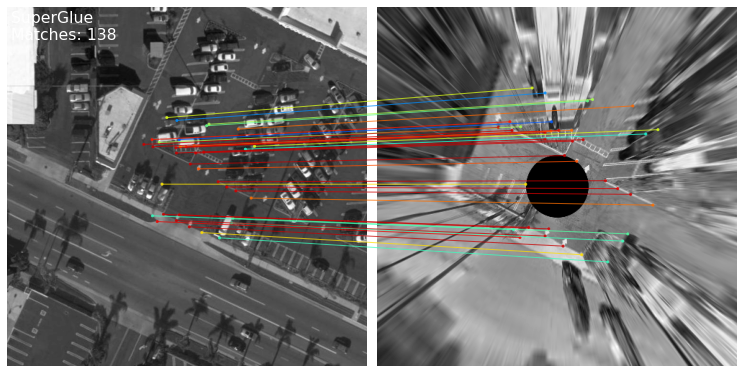

In [6]:
matAffine,mask = cv2.estimateAffinePartial2D(match_kpts1, match_kpts0, ransacReprojThreshold= 3) # , ransacReprojThreshold= 3
H_matAffine = np.zeros((3,3))
H_matAffine[:2,:3] = matAffine
H_matAffine[2,2] = 1
H = H_matAffine
print(match_kpts1[mask.reshape(-1)>0].shape )   # num_correct = np.sum(mask)
color = cm.jet(conf[top_idx[mask.reshape(-1)>0]], alpha=0.7)
fig = make_matching_figure(image0, image1, match_kpts0[mask.reshape(-1)>0], match_kpts1[mask.reshape(-1)>0], color, text =  text)
U, Sigma, V = np.linalg.svd(matAffine[:2, :2])
R = np.dot(U, V)
rot = np.arccos(R[0][0])
rot/np.pi*180

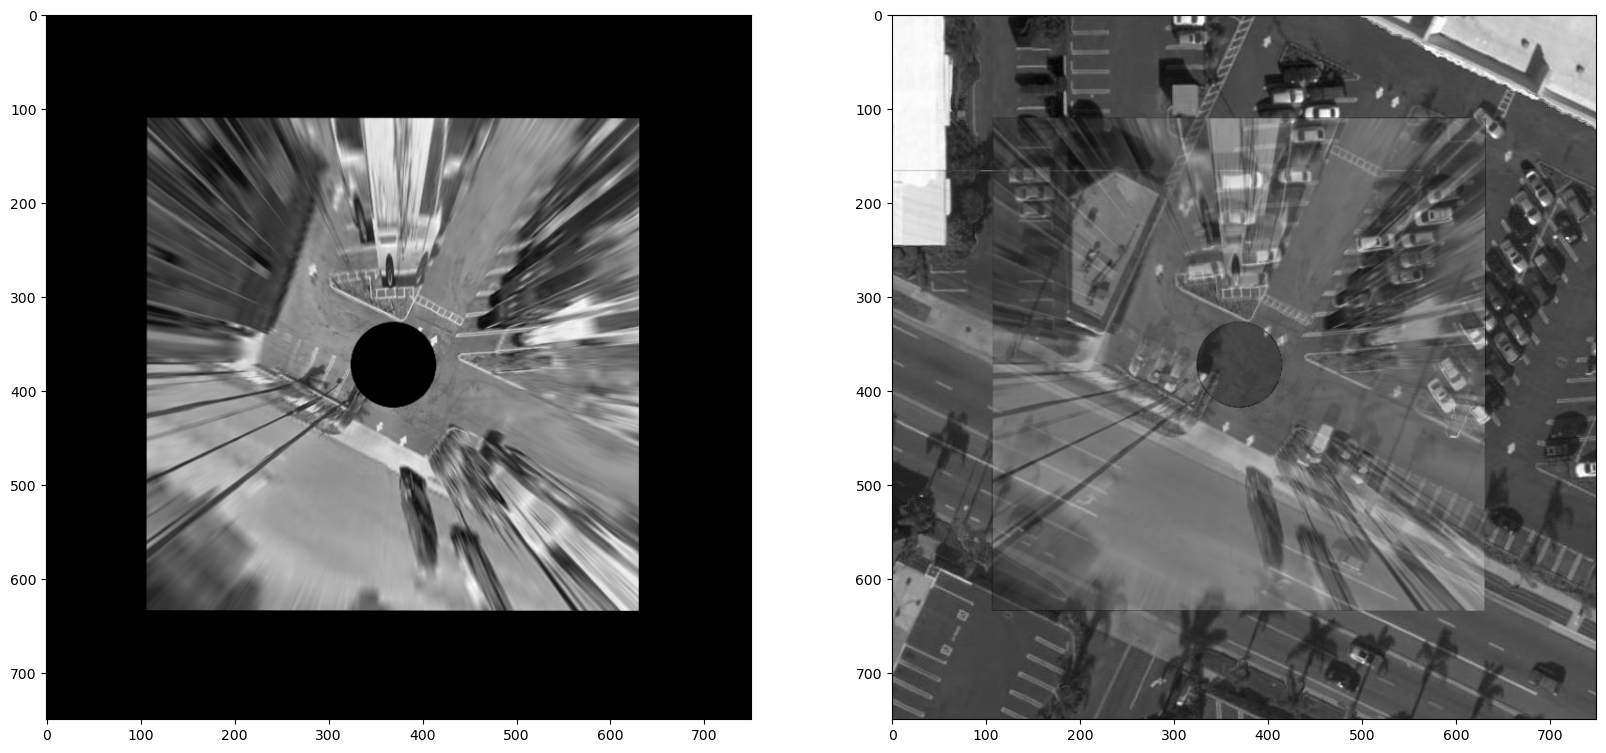

In [32]:
result = cv2.warpPerspective(image1, H, (image0.shape[1] + image1.shape[1], image0.shape[0]))
h,w = image0.shape[0],image0.shape[1]
mask_temp =result[:,0:w] > 1

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(result[:,0:w],cmap='gray')

temp = np.zeros((result[:,0:w].shape[0],result[:,0:w].shape[1],3))
for i in range(3):
    temp[:,:,i] = image0[:,:]
# 
temp2 = np.zeros((result[:,0:w].shape[0],result[:,0:w].shape[1],3))
for i in range(3):
    temp2[:,:,i] = result[:,0:w]
frame = temp.astype(np.uint8)
roi = frame[mask_temp]
frame[mask_temp] = (0.5*temp2.astype(np.uint8)[mask_temp] + 0.5 * roi).astype(np.uint8)
plt.subplot(1,2,2)
plt.imshow(frame)